In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import pandas as pd
from multiprocessing import Pool
from sys import getsizeof
from keras.utils import to_categorical
from sklearn.preprocessing import normalize

Using TensorFlow backend.


# Prepare data for training

## Read the csv file for training

In [2]:
######### Use pandas to read "bridge.csv","combats.csv" file #########


bridge_dfN = pd.read_csv('N.csv')
bridge_dfS = pd.read_csv('S.csv')  
bridge_dfE = pd.read_csv('E.csv')  
bridge_dfW = pd.read_csv('W.csv')

#bridge_dfN = pd.DataFrame(df_N)
#bridge_dfS = pd.DataFrame(df_S)
#bridge_dfE = pd.DataFrame(df_E)
#bridge_dfW = pd.DataFrame(df_W)

bridge_dfN = bridge_dfN[:2000]
bridge_dfS = bridge_dfS[:2000]
bridge_dfE = bridge_dfE[:2000]
bridge_dfW = bridge_dfW[:2000]

bridge_dfN = bridge_dfN.drop('lin_file',axis = 1)
bridge_dfN = bridge_dfN.drop('board_num',axis = 1)
bridge_dfS = bridge_dfS.drop('lin_file',axis = 1)
bridge_dfS = bridge_dfS.drop('board_num',axis = 1)
bridge_dfE = bridge_dfE.drop('lin_file',axis = 1)
bridge_dfE = bridge_dfE.drop('board_num',axis = 1)
bridge_dfW = bridge_dfW.drop('lin_file',axis = 1)
bridge_dfW = bridge_dfW.drop('board_num',axis = 1)


bridge_dfN['direction'] = 'N'
bridge_dfS['direction'] = 'S'
bridge_dfE['direction'] = 'E'
bridge_dfW['direction'] = 'W'
'''
bridge_dfN_test = bridge_dfN[500000:505000]
bridge_dfS_test = bridge_dfS[500000:505000]
bridge_dfE_test = bridge_dfE[500000:505000]
bridge_dfW_test = bridge_dfW[500000:505000]
'''




bridge_df = pd.concat([bridge_dfN, bridge_dfS], ignore_index=True)
bridge_df = pd.concat([bridge_df, bridge_dfE], ignore_index=True)
bridge_df = pd.concat([bridge_df, bridge_dfW], ignore_index=True)
#bridge_df = bridge_df.astype('int')
#df = pd.read_csv('combats.csv') 
#combats_df = df
#print(combats_df.iloc[:,:])
#print(len(combats_df.iloc[:,:]))
print(len(bridge_dfN.iloc[:,:]))
print(len(bridge_dfS.iloc[:,:]))
print(len(bridge_dfE.iloc[:,:]))
print(len(bridge_dfW.iloc[:,:]))

print(len(bridge_df.iloc[:,:]))

10
10
10
10
40


In [3]:
print(bridge_df.iloc[49998:50002])

       table_num value  self_value  op_value                      bidding_seq  \
49998          1  none           0         0  p|p|p|1C!|p|1D!|p|1S|p|4S|p|p|p   
49999          2    NS           1         0                 1H|2D|p|3N|p|p|p   
50000          2    NS           1         0   p|1C|p|1N|p|2D|p|2N|p|3N|p|p|p   
50001          3    EW           0         1              1H|2D|2N|p|4H|p|p|p   

       order suit_num sort_suit_num               suit             suits  \
49998      1  1|5|4|3       5|4|3|1  SQHQJ765DT863CQ43  Q|QJ765|T863|Q43   
49999      4  4|3|1|5       5|4|3|1  SQJ54HKJ8D4CKJ863  QJ54|KJ8|4|KJ863   
50000      4  4|3|1|5       5|4|3|1  SQJ54HKJ8D4CKJ863  QJ54|KJ8|4|KJ863   
50001      3  3|4|4|2       4|4|3|2  SQT4HJ864D9872CAQ  QT4|J864|9872|AQ   

       HCP_dis  HCP    short     void     long  winner_dis  winner  num_of_A  \
49998  2|3|0|2    7  1|0|0|0  0|0|0|0  0|1|0|0  0|2.75|1|0    3.75         0   
49999  3|4|0|4   11  0|0|1|0  0|0|0|0  0|0|0|1  1.75|

In [7]:
#print(bridge_dfW)  #set seq = 30num

train_data=[]
train_data_without_feature = []

for i in range(len(bridge_df.iloc[:,:])-1):
    if bridge_df.iloc[i,1] == 'none':
        bridge_df.iloc[i,1] = 0
    elif bridge_df.iloc[i,1] == 'NS':
        bridge_df.iloc[i,1] = 1
    elif bridge_df.iloc[i,1] == 'EW':
        bridge_df.iloc[i,1] = 2
    elif bridge_df.iloc[i,1] == 'both':
        bridge_df.iloc[i,1] = 3
    split_list = bridge_df.iloc[i,4].split('|')
    temp = 0
    temp_list_bidding =[-1]*12
    for j in range(len(split_list)):
        if(j>11):
            break;
        split_list[j] = split_list[j].replace("!", "")
        if(split_list[j][0]=='p' or split_list[j][0]=='P'):
            temp_list_bidding[j]=0
            continue
        if(split_list[j][0]=='d' or split_list[j][0]=='D'):
            temp_list_bidding[j]=36
            continue
        if(split_list[j][0]=='r' or split_list[j][0]=='R'):
            temp_list_bidding[j]=37
            continue
                
                
        temp = 0
        if(len(split_list[j]) != 2):
            temp = -1
            break
        if(split_list[j][0].isdigit()):
            temp += (int(split_list[j][0])-1)*5
        if(split_list[j][1] == 'C' or split_list[j][1] == 'c'):
            temp += 1
        elif(split_list[j][1] == 'D' or split_list[j][1] == 'd' ):
            temp += 2
        elif(split_list[j][1] == 'H' or split_list[j][1] == 'h'):
            temp += 3
        elif(split_list[j][1] == 'S' or split_list[j][1] == 's'):
            temp += 4
        elif(split_list[j][1] == 'N' or split_list[j][1] == 'n'):
            temp += 5
        else:
            temp = -1
            break
        temp_list_bidding[j] = temp
        
    temp_list = []
    without_feature = []
    temp_list.append(bridge_df.iloc[i,0])
    without_feature.append(bridge_df.iloc[i,0])
    temp_list.append(bridge_df.iloc[i,1])
    without_feature.append(bridge_df.iloc[i,1])
    temp_list.append(bridge_df.iloc[i,2])
    without_feature.append(bridge_df.iloc[i,2])
    temp_list.append(bridge_df.iloc[i,3])
    without_feature.append(bridge_df.iloc[i,3])
    for j in range(12):
        temp_list.append(temp_list_bidding[j])
        without_feature.append(temp_list_bidding[j])
    temp_list.append(bridge_df.iloc[i,5])
    without_feature.append(bridge_df.iloc[i,5])

    split_list6 = bridge_df.iloc[i,6].split('|')
    for j in range(4):
        temp_list.append(split_list6[j])
    '''
    split_list7 = bridge_df.iloc[i,7].split('|')
    for j in range(4):
        temp_list.append(split_list7[j])
    '''
    split_list9 = bridge_df.iloc[i,9].split('|')    
    for j in range(4):
        suit = [0]*13
        for k in range(len(split_list9[j])):
            if split_list9[j][k] == 'A':
                suit[1] = 1
            elif split_list9[j][k] == 'K':
                suit[0] = 1
            elif split_list9[j][k] == 'Q':
                suit[12] = 1
            elif split_list9[j][k] == 'J':
                suit[11] = 1
            elif split_list9[j][k] == 'T':
                suit[10] = 1
            elif split_list9[j][k].isdigit():
                suit[int(split_list9[j][k])] = 1
            else:
                suit[k] = -1
        without_feature = without_feature + suit
        temp_list = temp_list + suit
        
    split_list10 = bridge_df.iloc[i,10].split('|')
    for j in range(4):
        temp_list.append(split_list10[j])
    temp_list.append(bridge_df.iloc[i,11])
    
    split_list12 = bridge_df.iloc[i,12].split('|')
    for j in range(4):
        temp_list.append(split_list12[j])
    split_list13 = bridge_df.iloc[i,13].split('|')
    for j in range(4):
        temp_list.append(split_list13[j])
    split_list14 = bridge_df.iloc[i,14].split('|')
    for j in range(4):
        temp_list.append(split_list14[j])
    split_list15 = bridge_df.iloc[i,15].split('|')
    for j in range(4):
        temp_list.append(split_list15[j])
    
    temp_list.append(bridge_df.iloc[i,16])
    temp_list.append(bridge_df.iloc[i,17])
    if(bridge_df.iloc[i,18] == 'N'):
        temp_list.append(0)
    elif(bridge_df.iloc[i,18] == 'S'):
        temp_list.append(1)
    elif(bridge_df.iloc[i,18] == 'E'):
        temp_list.append(2)
    elif(bridge_df.iloc[i,18] == 'W'):
        temp_list.append(3)
    else:
        temp_list.append(-1)
        
    
    train_data.append(temp_list)
    train_data_without_feature.append(without_feature)

print(len(train_data))
print('hihi\n\n\n\n\n\n\n\n')
train_data = np.asarray(train_data)
print(train_data.shape)
train_data_without_feature = np.asarray(train_data_without_feature)
train_data = train_data.astype('float')
train_data_without_feature = train_data_without_feature.astype('float')
print(train_data[0])
print(train_data[999])
print(train_data)
print(train_data.shape)

39
hihi








(39, 97)
[ 1.   0.   0.   0.   0.   9.   0.   0.   0.  -1.  -1.  -1.  -1.  -1.
 -1.  -1.   1.   3.   3.   4.   3.   0.   0.   0.   0.   0.   1.   1.
  0.   0.   0.   0.   1.   0.   0.   1.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   1.   1.   0.   0.   0.   0.   1.   0.   1.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.
  0.   0.   1.   1.   7.   2.   2.  12.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   2.5  1.   0.   3.5  1.   0. ]


IndexError: index 999 is out of bounds for axis 0 with size 39

In [5]:
train_data_without_feature = []

for i in range(len(bridge_df.iloc[:,:])-1):
    if bridge_df.iloc[i,1] == 'none':
        bridge_df.iloc[i,1] = 0
    elif bridge_df.iloc[i,1] == 'NS':
        bridge_df.iloc[i,1] = 1
    elif bridge_df.iloc[i,1] == 'EW':
        bridge_df.iloc[i,1] = 2
    elif bridge_df.iloc[i,1] == 'both':
        bridge_df.iloc[i,1] = 3
    split_list = bridge_df.iloc[i,4].split('|')
    temp = 0
    temp_list_bidding =[-1]*12
    for j in range(len(split_list)):
        if(j>11):
            break;
        split_list[j] = split_list[j].replace("!", "")
        if(split_list[j][0]=='p' or split_list[j][0]=='P'):
            temp_list_bidding[j]=0
            continue
        if(split_list[j][0]=='d' or split_list[j][0]=='D'):
            temp_list_bidding[j]=36
            continue
        if(split_list[j][0]=='r' or split_list[j][0]=='R'):
            temp_list_bidding[j]=37
            continue
                
                
        temp = 0
        if(len(split_list[j]) != 2):
            temp = -1
            break
        if(split_list[j][0].isdigit()):
            temp += (int(split_list[j][0])-1)*5
        if(split_list[j][1] == 'C' or split_list[j][1] == 'c'):
            temp += 1
        elif(split_list[j][1] == 'D' or split_list[j][1] == 'd' ):
            temp += 2
        elif(split_list[j][1] == 'H' or split_list[j][1] == 'h'):
            temp += 3
        elif(split_list[j][1] == 'S' or split_list[j][1] == 's'):
            temp += 4
        elif(split_list[j][1] == 'N' or split_list[j][1] == 'n'):
            temp += 5
        else:
            temp = -1
            break
        temp_list_bidding[j] = temp
        
    without_feature = []
    without_feature.append(bridge_df.iloc[i,0])
    without_feature.append(bridge_df.iloc[i,1])
    without_feature.append(bridge_df.iloc[i,2])
    without_feature.append(bridge_df.iloc[i,3])
    for j in range(12):
        without_feature.append(temp_list_bidding[j])
        
    without_feature.append(bridge_df.iloc[i,5])
    
    split_list9 = bridge_df.iloc[i,9].split('|')    
    for j in range(4):
        suit = [0]*13
        for k in range(len(split_list9[j])):
            if split_list9[j][k] == 'A':
                suit[1] = 1
            elif split_list9[j][k] == 'K':
                suit[0] = 1
            elif split_list9[j][k] == 'Q':
                suit[12] = 1
            elif split_list9[j][k] == 'J':
                suit[11] = 1
            elif split_list9[j][k] == 'T':
                suit[10] = 1
            elif split_list9[j][k].isdigit():
                suit[int(split_list9[j][k])] = 1
            else:
                suit[k] = -1
        without_feature = without_feature + suit
        
    train_data_without_feature.append(without_feature)
train_data_without_feature = np.asarray(train_data_without_feature)
train_data_without_feature = train_data_without_feature.astype('float')
print(train_data_without_feature[0])
print(train_data_without_feature[999])
print(train_data_without_feature)
print(train_data_without_feature.shape)

KeyboardInterrupt: 

## Make the training data

In [ ]:

train_data_org = train_data
train_data_backup = train_data

In [ ]:
#np.savetxt('train_data_savefile_200000.txt', train_data, fmt='%f')
np.savetxt('train_data_without_feature_savefile.txt', train_data_without_feature, fmt='%f')
train_data = []
train_data_without_feature = []
#train_data = np.loadtxt('train_data_savefile_200000.txt', dtype=float)
train_data_without_feature = np.loadtxt('train_data_without_feature_savefile.txt', dtype=float)
print(train_data[0])
print(train_data[999])
print(train_data)
print(train_data.shape)

In [9]:
np.savetxt('train_data_without_feature_savefile.txt', train_data_without_feature, fmt='%f')
train_data_without_feature = []
train_data_without_feature = np.loadtxt('train_data_without_feature_savefile.txt', dtype=float)
print(train_data_without_feature[0])
print(train_data_without_feature[999])
print(train_data_without_feature)
print(train_data_without_feature.shape)

[ 1.  0.  0.  0.  0.  9.  0.  0.  0. -1. -1. -1. -1. -1. -1. -1.  1.  0.
  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  1.  1.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.]
[12.  1.  1.  0.  0.  5. 36.  8.  0.  0.  0. -1. -1. -1. -1. -1.  2.  0.
  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.  1.  0.
  0.  1.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.]
[[ 1.  0.  0. ...  0.  0.  1.]
 [ 1.  0.  0. ...  0.  0.  1.]
 [ 2.  1.  1. ...  0.  0.  0.]
 ...
 [20.  3.  1. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]]
(199999, 69)


In [ ]:


train_data[:,0] = train_data[:,0]/50
train_data[:,1] = train_data[:,1]/3
train_data[:,4:15] = train_data[:,4:15]/37
train_data[:,16] = train_data[:,16]/4
train_data[:,17:20] = train_data[:,17:20]/13
train_data[:,73:76] = train_data[:,73:76]/13
train_data[:,81] = train_data[:,81]/30
train_data[:,91:94] = train_data[:,91:94]/10
train_data[:,95] = train_data[:,95]/10
train_data[:,96] = train_data[:,96]/10
'''
train_data[:,0] = train_data[:,0]*50
train_data[:,1] = train_data[:,1]*3
train_data[:,4] = train_data[:,4]*2000
train_data[:,5] = train_data[:,5]*4
train_data[:,6:13] = train_data[:,6:13]*13
train_data[:,66:69] = train_data[:,66:69]*13
train_data[:,70] = train_data[:,70]*30
train_data[:,83:86] = train_data[:,83:86]*10
train_data[:,87] = train_data[:,87]*10
'''
print(train_data[0,:])
print(train_data)
print(train_data.shape)
print(type(train_data))

In [11]:
train_data_without_feature = normalize(train_data_without_feature, axis=0, norm='max')

## Make one-hot format labels (But bridge seems to use 13-hot-encoding)

In [21]:
from keras.utils import np_utils
#train_labels[i][1]:
#combats_df.iloc[:,2]

combats_train_hot_label = [[0 for x in range(38)] for y in range(199999)]

for i in range(len(bridge_df.iloc[:,:])-1):
    split_list = bridge_df.iloc[i,4].split('|')
    order = int(bridge_df.iloc[i,5])-1
    
    if(order+1>len(split_list)):
        combats_train_hot_label[i][0] = 1
        continue
    
    split_list[order] = split_list[order].replace("!", "")
    if(split_list[order]=='p' or split_list[order]=='p!' or split_list[order]=='P' or split_list[order]=='P!'):
        combats_train_hot_label[i][0] = 1
        
    elif(split_list[order]=='d' or split_list[order]=='d!' or split_list[order]=='D' or split_list[order]=='D!'):
        combats_train_hot_label[i][36] = 1
    elif(split_list[order]=='r' or split_list[order]=='r!' or split_list[order]=='R' or split_list[order]=='R!'):
        combats_train_hot_label[i][37] = 1
    temp_num = 0    
    if (len(split_list[order]) == 2 and split_list[order][0].isdigit()):
        temp_num = (int(split_list[order][0])-1)*5
        if(split_list[order][1] == 'C' or split_list[order][1] == 'c'):
            temp_num += 1
        elif(split_list[order][1] == 'D' or split_list[order][1] == 'd' ):
            temp_num += 2
        elif(split_list[order][1] == 'H' or split_list[order][1] == 'h'):
            temp_num += 3
        elif(split_list[order][1] == 'S' or split_list[order][1] == 's'):
            temp_num += 4
        elif(split_list[order][1] == 'N' or split_list[order][1] == 'n'): 
            temp_num += 5
        else:
            temp_num = 0
        combats_train_hot_label[i][temp_num] = 1 
    

#combats_train_hot_label = np_utils.to_categorical(combats_train_label,2)

combats_train_hot_label = np.asarray(combats_train_hot_label)
print(combats_train_hot_label[56][:])
print(combats_train_hot_label)
print(combats_train_hot_label.shape)
print(type(combats_train_hot_label))




[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]
(199999, 38)
<class 'numpy.ndarray'>


In [22]:
np.savetxt('combats_train_hot_label_without_feature.txt', combats_train_hot_label, fmt='%f')
combats_train_hot_label = np.loadtxt('combats_train_hot_label_without_feature.txt', dtype=float)
print(combats_train_hot_label[0])
print(combats_train_hot_label[999])
print(combats_train_hot_label)
print(combats_train_hot_label.shape)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
(199999, 38)


In [23]:
#combats_train_hot_label = to_categorical(combats_train_hot_label,2)
combats_train_hot_label = combats_train_hot_label.astype(float)
print(combats_train_hot_label.shape)
print(type(combats_train_hot_label))
print(combats_train_hot_label[0,:])
print(combats_train_hot_label)

print(train_data.shape)
print(type(train_data))
print(train_data[0,:])
print(train_data)

(199999, 38)
<class 'numpy.ndarray'>
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
(199999, 97)
<class 'numpy.ndarray'>
[ 1.   0.   0.   0.   0.   9.   0.   0.   0.  -1.  -1.  -1.  -1.  -1.
 -1.  -1.   1.   3.   3.   4.   3.   0.   0.   0.   0.   0.   1.   1.
  0.   0.   0.   0.   1.   0.   0.   1.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   1.   1.   0.   0.   0.   0.   1.   0.   1.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.
  0.   0.   1.   1.   7.   2.   2.  12.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   2.5  1.   0.   3.5  1.   0. ]
[[ 1.   0.   0.  ...  3.5  1.   0. ]
 [ 1.   0.   0.  ...  3.5  1.   0. ]
 [ 2.   1.   1.  ...  2.5  0.   0. ]
 ...
 [20.   3.   1.  ...  4.5  0.   3. ]
 [ 1.   0.   

# Build Model

##  Create network

In [16]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras import optimizers
from keras.models import load_model

from keras.datasets import mnist
from keras.utils import np_utils
import keras.callbacks
import os
import os.path
import glob
from keras.layers import Dropout
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers.normalization import BatchNormalization
from keras.layers import Embedding
from keras import optimizers

In [19]:
def build_model():
    model = Sequential()
    ###   code here  #####
    #keras.layers.normalization.BatchNormalization(epsilon=1e-06, mode=0, momentum=0.9, weights=None)
    
    model.add(Dense(128,input_shape = (69,))) #need to check the input size, first set the input node to be 128 as matlab do
    model.add(Activation('relu')) #might be leakyRelu, since they used the parameter alpha, still need to check
    model.add(BatchNormalization())
    model.add(Dropout(0.7))
    
    model.add(Dense(784))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.7))
    
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.7))

    model.add(Dense(38,activation='softmax')) #need to check the output size, seems to be 36
    model.summary()
    return model

## Training

In [24]:
############## Start Training ############
# use validation_data=(valid_data,valid_labels) in model.fit !!!!!! #
'''
training parameters
update_dnntype = 2; 
badupdate_dnn = 2; 
explore_first = 1; 
alphaupdate_dnn = 0.1;
batchsizeupdate_dnn = 50;
batchsize = 50;
decayRate = 0.98;
momentum = 0.82;
alpha = 0.83;
startbackprop = 0;
input = 52+36+5;
lsize = 128;
layer = 4;
output = 36;
eta = 0.05;
'''
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=20, verbose=1, mode='auto')
model = build_model()
sgd = optimizers.SGD(lr=0.2, clipnorm=1.0
                     ,decay = 1e-08 #original 1e-08
                    )
adadelta = optimizers.Adadelta(lr=1.0, epsilon=None, decay=0.0)
model.compile(optimizer= adadelta#as bridge
            #,loss='categorical_crossentropy'
            ,loss='categorical_crossentropy'
            ,metrics=['accuracy'])

record = model.fit(train_data_without_feature,combats_train_hot_label
                   ,batch_size=4096 #original 64
                   ,epochs=1000
                   ,validation_split = 0.1
                   ,callbacks=[earlyStopping]
                   ,shuffle = True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               8960      
_________________________________________________________________
activation_7 (Activation)    (None, 128)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)               512       
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 784)               101136    
_________________________________________________________________
activation_8 (Activation)    (None, 784)               0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 784)               3136      
__________

179999/179999 [==============================] - 1s 6us/step - loss: 0.8806 - acc: 0.7367 - val_loss: 0.5890 - val_acc: 0.8120
Epoch 103/1000
179999/179999 [==============================] - 1s 6us/step - loss: 0.8786 - acc: 0.7377 - val_loss: 0.5826 - val_acc: 0.8117
Epoch 104/1000
179999/179999 [==============================] - 1s 6us/step - loss: 0.8761 - acc: 0.7382 - val_loss: 0.5716 - val_acc: 0.8136
Epoch 105/1000
179999/179999 [==============================] - 1s 6us/step - loss: 0.8716 - acc: 0.7393 - val_loss: 0.5658 - val_acc: 0.8179
Epoch 106/1000
179999/179999 [==============================] - 1s 6us/step - loss: 0.8628 - acc: 0.7414 - val_loss: 0.5693 - val_acc: 0.8167
Epoch 107/1000
179999/179999 [==============================] - 1s 6us/step - loss: 0.8632 - acc: 0.7418 - val_loss: 0.5766 - val_acc: 0.8147
Epoch 108/1000
179999/179999 [==============================] - 1s 6us/step - loss: 0.8584 - acc: 0.7421 - val_loss: 0.5799 - val_acc: 0.8130
Epoch 109/1000
179999

In [25]:
model.save('bridge_model_200000_without_feature.h5') 

## Plot the training results

Train loss: 0.5272756095882635
Train accuracy: 0.8344591722925833


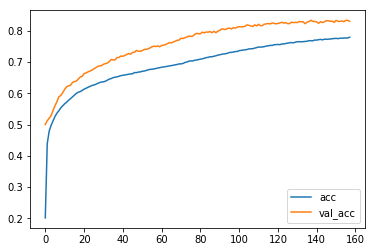

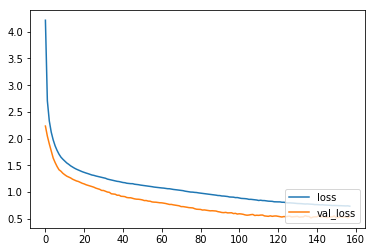

In [26]:
score = model.evaluate(train_data_without_feature, combats_train_hot_label, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
plt.plot(record.history['acc'],label='acc')
plt.plot(record.history['val_acc'],label='val_acc')
plt.legend(loc='lower right')
plt.show()
plt.plot(record.history['loss'],label='loss')
plt.plot(record.history['val_loss'],label='val_loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
'''import csv
bridge_df_test = []

bridge_df_test = pd.concat([bridge_dfN_test, bridge_dfS_test], ignore_index=True)
bridge_df_test = pd.concat([bridge_df_test, bridge_dfE_test], ignore_index=True)
bridge_df_test = pd.concat([bridge_df_test, bridge_dfW_test], ignore_index=True)

bridge_df_test.to_csv("bridge_test", encoding='utf-8', index=False)'''


# Testing

## Read testing data

In [ ]:
df = pd.read_csv('bridge_test.csv') 
test_df = df


print(len(test_df.iloc[:,:]))
print(test_df.iloc[:,:].shape)
#print(test_df)

test_data=[]

for i in range(len(test_df.iloc[:,:])-1):
    if test_df.iloc[i,1] == 'none':
        test_df.iloc[i,1] = 0
    elif test_df.iloc[i,1] == 'NS':
        test_df.iloc[i,1] = 1
    elif test_df.iloc[i,1] == 'EW':
        test_df.iloc[i,1] = 2
    elif test_df.iloc[i,1] == 'both':
        test_df.iloc[i,1] = 3
    split_list = test_df.iloc[i,4].split('|')
    temp = 0
    temp_list_bidding =[-1]*12
    for j in range(len(split_list)):
        if(j>11):
            break;
        split_list[j] = split_list[j].replace("!", "")
        if(split_list[j][0]=='p' or split_list[j][0]=='P'):
            temp_list_bidding[j]=0
            continue
        if(split_list[j][0]=='d' or split_list[j][0]=='D'):
            temp_list_bidding[j]=36
            continue
        if(split_list[j][0]=='r' or split_list[j][0]=='R'):
            temp_list_bidding[j]=37
            continue
                
                
        temp = 0
        if(len(split_list[j]) != 2):
            temp = -1
            break
        if(split_list[j][0].isdigit()):
            temp += (int(split_list[j][0])-1)*5
        if(split_list[j][1] == 'C' or split_list[j][1] == 'c'):
            temp += 1
        elif(split_list[j][1] == 'D' or split_list[j][1] == 'd' ):
            temp += 2
        elif(split_list[j][1] == 'H' or split_list[j][1] == 'h'):
            temp += 3
        elif(split_list[j][1] == 'S' or split_list[j][1] == 's'):
            temp += 4
        elif(split_list[j][1] == 'N' or split_list[j][1] == 'n'):
            temp += 5
        else:
            temp = -1
            break
        temp_list_bidding[j] = temp
        
    temp_list = []
    temp_list.append(test_df.iloc[i,0])
    temp_list.append(test_df.iloc[i,1])
    temp_list.append(test_df.iloc[i,2])
    temp_list.append(test_df.iloc[i,3])
    for j in range(12):
        temp_list.append(temp_list_bidding[j])
    temp_list.append(test_df.iloc[i,5])

    split_list6 = test_df.iloc[i,6].split('|')
    for j in range(4):
        temp_list.append(split_list6[j])
    '''
    split_list7 = test_df.iloc[i,7].split('|')
    for j in range(4):
        temp_list.append(split_list7[j])
    '''
    split_list9 = test_df.iloc[i,9].split('|')    
    for j in range(4):
        suit = [0]*13
        for k in range(len(split_list9[j])):
            if split_list9[j][k] == 'A':
                suit[1] = 1
            elif split_list9[j][k] == 'K':
                suit[0] = 1
            elif split_list9[j][k] == 'Q':
                suit[12] = 1
            elif split_list9[j][k] == 'J':
                suit[11] = 1
            elif split_list9[j][k] == 'T':
                suit[10] = 1
            elif split_list9[j][k].isdigit():
                suit[int(split_list9[j][k])] = 1
            else:
                suit[k] = -1
        temp_list = temp_list + suit
        
    split_list10 = test_df.iloc[i,10].split('|')
    for j in range(4):
        temp_list.append(split_list10[j])
    temp_list.append(test_df.iloc[i,11])
    
    split_list12 = test_df.iloc[i,12].split('|')
    for j in range(4):
        temp_list.append(split_list12[j])
    split_list13 = test_df.iloc[i,13].split('|')
    for j in range(4):
        temp_list.append(split_list13[j])
    split_list14 = test_df.iloc[i,14].split('|')
    for j in range(4):
        temp_list.append(split_list14[j])
    split_list15 = test_df.iloc[i,15].split('|')
    for j in range(4):
        temp_list.append(split_list15[j])
    
    temp_list.append(test_df.iloc[i,16])
    temp_list.append(test_df.iloc[i,17])
    if(test_df.iloc[i,18] == 'N'):
        temp_list.append(0)
    elif(test_df.iloc[i,18] == 'S'):
        temp_list.append(1)
    elif(test_df.iloc[i,18] == 'E'):
        temp_list.append(2)
    elif(test_df.iloc[i,18] == 'W'):
        temp_list.append(3)
    else:
        temp_list.append(-1)
        
    
    test_data.append(temp_list)

test_data = np.asarray(test_data)
test_data = test_data.astype('float')
print(test_data[0])
print(test_data[999])
print(test_data)
print(test_data.shape)

test_data[:,0] = test_data[:,0]/50
test_data[:,1] = test_data[:,1]/3
test_data[:,4:15] = test_data[:,4:15]/37
test_data[:,16] = test_data[:,16]/4
test_data[:,17:20] = test_data[:,17:20]/13
test_data[:,73:76] = test_data[:,73:76]/13
test_data[:,81] = test_data[:,81]/30
test_data[:,91:94] = test_data[:,91:94]/10
test_data[:,95] = test_data[:,95]/10
test_data[:,96] = test_data[:,96]/10


print(test_data.shape)
print(type(test_data))
print(test_data[0,:])
print(test_data)


In [30]:
df = pd.read_csv('bridge_test.csv') 
test_df = df


print(len(test_df.iloc[:,:]))
print(test_df.iloc[:,:].shape)
#print(test_df)

test_data=[]

for i in range(len(test_df.iloc[:,:])-1):
    if test_df.iloc[i,1] == 'none':
        test_df.iloc[i,1] = 0
    elif test_df.iloc[i,1] == 'NS':
        test_df.iloc[i,1] = 1
    elif test_df.iloc[i,1] == 'EW':
        test_df.iloc[i,1] = 2
    elif test_df.iloc[i,1] == 'both':
        test_df.iloc[i,1] = 3
    split_list = test_df.iloc[i,4].split('|')
    temp = 0
    temp_list_bidding =[-1]*12
    for j in range(len(split_list)):
        if(j>11):
            break;
        split_list[j] = split_list[j].replace("!", "")
        if(split_list[j][0]=='p' or split_list[j][0]=='P'):
            temp_list_bidding[j]=0
            continue
        if(split_list[j][0]=='d' or split_list[j][0]=='D'):
            temp_list_bidding[j]=36
            continue
        if(split_list[j][0]=='r' or split_list[j][0]=='R'):
            temp_list_bidding[j]=37
            continue
                
                
        temp = 0
        if(len(split_list[j]) != 2):
            temp = -1
            break
        if(split_list[j][0].isdigit()):
            temp += (int(split_list[j][0])-1)*5
        if(split_list[j][1] == 'C' or split_list[j][1] == 'c'):
            temp += 1
        elif(split_list[j][1] == 'D' or split_list[j][1] == 'd' ):
            temp += 2
        elif(split_list[j][1] == 'H' or split_list[j][1] == 'h'):
            temp += 3
        elif(split_list[j][1] == 'S' or split_list[j][1] == 's'):
            temp += 4
        elif(split_list[j][1] == 'N' or split_list[j][1] == 'n'):
            temp += 5
        else:
            temp = -1
            break
        temp_list_bidding[j] = temp
        
    without_feature = []
    without_feature.append(test_df.iloc[i,0])
    without_feature.append(test_df.iloc[i,1])
    without_feature.append(test_df.iloc[i,2])
    without_feature.append(test_df.iloc[i,3])
    for j in range(12):
        without_feature.append(temp_list_bidding[j])
        
    without_feature.append(test_df.iloc[i,5])
    
    split_list9 = test_df.iloc[i,9].split('|')    
    for j in range(4):
        suit = [0]*13
        for k in range(len(split_list9[j])):
            if split_list9[j][k] == 'A':
                suit[1] = 1
            elif split_list9[j][k] == 'K':
                suit[0] = 1
            elif split_list9[j][k] == 'Q':
                suit[12] = 1
            elif split_list9[j][k] == 'J':
                suit[11] = 1
            elif split_list9[j][k] == 'T':
                suit[10] = 1
            elif split_list9[j][k].isdigit():
                suit[int(split_list9[j][k])] = 1
            else:
                suit[k] = -1
        without_feature = without_feature + suit
        
    test_data.append(without_feature)
    
test_data = np.asarray(test_data)
test_data = test_data.astype('float')

print(test_data[0])
print(test_data[999])
print(test_data)
print(test_data.shape)



20000
(20000, 19)
[10.  3.  1.  1.  4.  0.  9. 13.  0. 18.  0.  0.  0. -1. -1. -1.  4.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  0.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  1.  0.  1.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[22.  2.  0.  1.  1.  3.  5. 12.  0.  0.  0. -1. -1. -1. -1. -1.  4.  0.
  0.  1.  0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  1.  1.
  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  1.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[[10.  3.  1. ...  0.  0.  0.]
 [11.  0.  0. ...  0.  1.  0.]
 [11.  0.  0. ...  0.  1.  0.]
 ...
 [14.  0.  0. ...  0.  0.  0.]
 [14.  0.  0. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  1.  0.]]
(19999, 69)


In [31]:
test_data = normalize(test_data, axis=0, norm='max')
print(test_data.shape)
print(type(test_data))
print(test_data[0,:])
print(test_data)

(19999, 69)
<class 'numpy.ndarray'>
[ 0.09803922  1.          1.          1.          0.11428571  0.
  0.24324324  0.35135135  0.          0.48648649  0.          0.
  0.         -0.02702703 -0.02702703 -0.02702703  1.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  1.          1.          1.          1.          0.          1.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          1.          1.
  0.          0.          0.          1.          0.          1.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
[[0.09803922 1.         1.         ... 0.         0.         0.        ]
 [0.10784314 0.         0.         ... 0.         1.         0.        ]
 [0.10784314 0.         0.         ... 0.         1.         0.  

## Predict results

In [32]:
###### use "model.predict(testing_data)" to get the results ######
pred = np.argmax(model.predict(test_data), axis=1).reshape(19999,1)
predicted_output_df = pd.DataFrame(pred, columns = ["card output"])  #predicted output
output = pd.read_csv('bridge_test_output1.csv') #real ouput

count = 0
for i in range(19999):
    if(predicted_output_df.iloc[i][0]==output.iloc[i][0]):
        count+=1

print(count/19999)
print(count)


0.22581129056452823
4516


## Print the result to csv file

In [ ]:
df.to_csv('result.csv',index_label = "index")